# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Oganes Manasian, Maksim Kriukov, Henry Declety
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

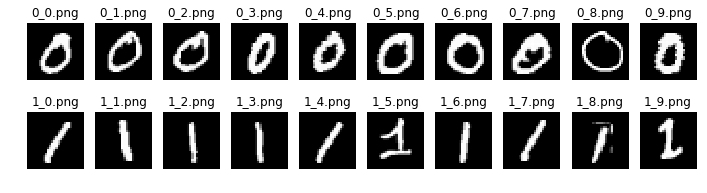

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load twos
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

In [4]:
from skimage.morphology import binary_erosion
from skimage.morphology import diameter_opening
import numpy as np
import cmath
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.manifold import TSNE
from numpy.linalg import eig
import pandas as pd

sns.set()  # Setting seaborn aesthetics for making pretty plots

#### Pre-processing

We will first start with Fourier descriptors as recommended. To extract these features we should first do segmentation of our objects and isolate contours. To achieve that we should understand the distribution of the raw pixels in our images. Let us make a quick histogram of the pixel values for the first image of zero.

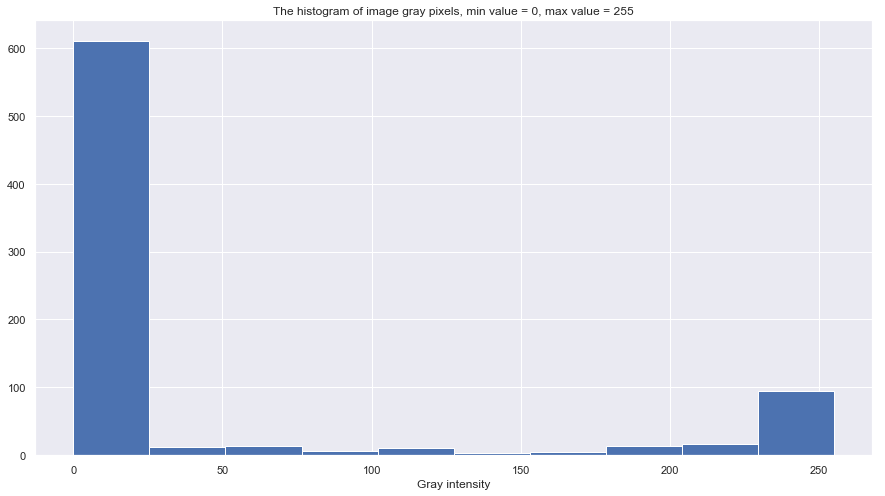

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(zeros_im[0].ravel())
ax.set_xlabel('Gray intensity')
ax.set_title('The histogram of image gray pixels, min value = %d, max value = %d' % (zeros_im[0].min().min(), zeros_im[0].max().max()));

We could conclude that that gray pixel levels have a bimodal distribution, with dark pixels being background, and bright pixel being our digits. As gray levels are between 0 and 256, we would put a threshold for separating our objects in the middle - at 128. Let us make sure that this assumption would result in correct segmentation for zeros and ones.

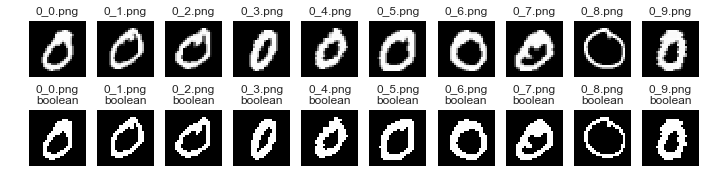

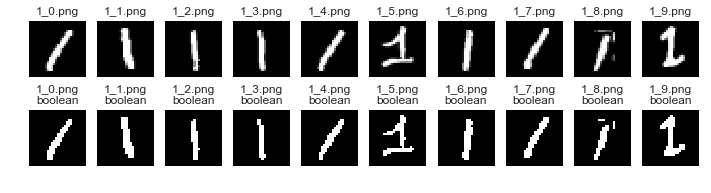

In [6]:
# Plot segmented objects

# Compute the object regions
zero_regions = [image > 128 for image in zeros_im]
one_regions = [image > 128 for image in ones_im]

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, img, name, ax2, img2 in zip(axes[0], zeros_im, zeros_names, axes[1], zero_regions):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(name + '\nboolean')
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))    
for ax, img, name, ax2, img2 in zip(axes[0], ones_im, ones_names, axes[1], one_regions):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(name + '\nboolean')

We could observe that our objects are nicely isolated with our manual threshold. Now using that we could focus on isolating the contours of our objects.

To isolate the contours of the object we will remove an erosed version of the image from the original one.

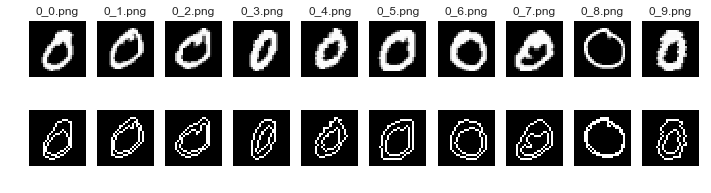

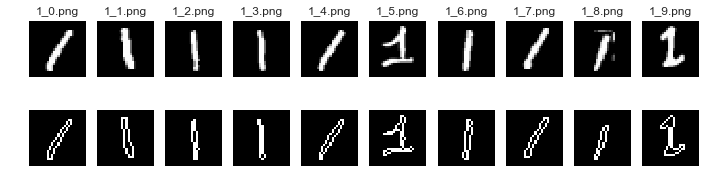

In [7]:
zero_contours = []
one_contours = []

def get_contour(image):
    # Make the image binary (only 0s and 1s)
    booleans_list = image > 128
    binary = np.array([[1 if boolean else 0 for boolean in booleans] for booleans in booleans_list])
    
    # We make an opening big enough to remove stains (like in 1_8.png)
    opening = skimage.morphology.diameter_opening(binary, 4.5)
    
    # Then we create an erosed image
    erosion = skimage.morphology.binary_erosion(opening)
    
    # And finally remove that erosed image from the original one (XOR operation), leaving only the contour.
    return skimage.morphology.binary_erosion(opening) ^ opening

# Compute contours
zero_contours = [get_contour(img) for img in zeros_im]
one_contours = [get_contour(img) for img in ones_im]
    
# Plot
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, img, name, ax2, img2 in zip(axes[0], zeros_im, zeros_names, axes[1], zero_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))    
for ax, img, name, ax2, img2 in zip(axes[0], ones_im, ones_names, axes[1], one_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Outside contour with successive points


In [8]:
def get_outside_contours(images):
    # Getting outside contour starting with top middle point and going in
    # counter-clockwise order.
    
    neighbors = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
    arrow = 0
    contours = []
    
    for image in np.array(images):
        contour = []
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i,j]: 

                    last_pix = (i,j)
                    arrow = 0
                    contour.append((i,j))
                    break
            if len(contour): break

        if len(contour):
            while contour[0] != contour[-1] or len(contour)==1 :
                for i in range(len(neighbors)):
                    direction = neighbors[ (arrow+i)%len(neighbors) ]
                    new_pix = (contour[-1][0]+direction[0],contour[-1][1]+direction[1])

                    if image[new_pix[0],new_pix[1]]:
                        contour.append((new_pix))
                        arrow = (arrow+i - 2)%len(neighbors)
                        break
        contours.append(contour)
    return contours

Here we use shades of gray to show how the points are ordered.

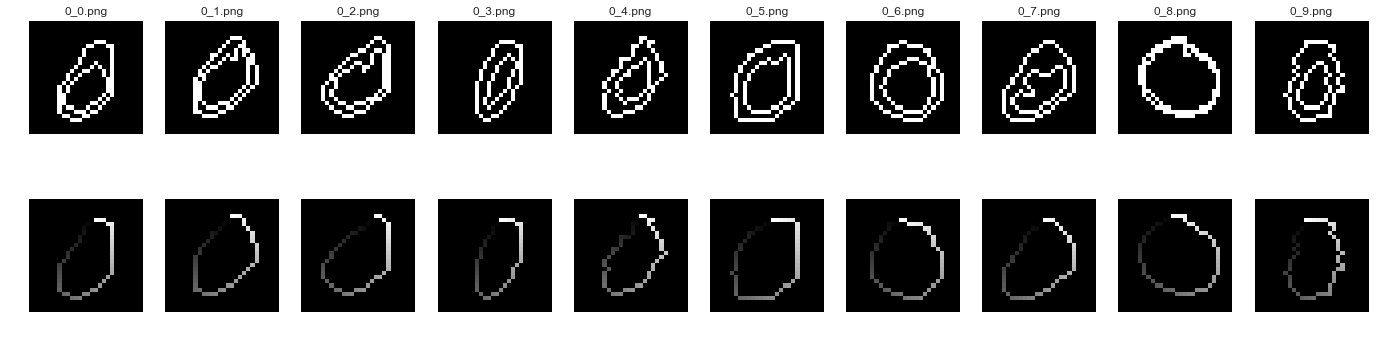

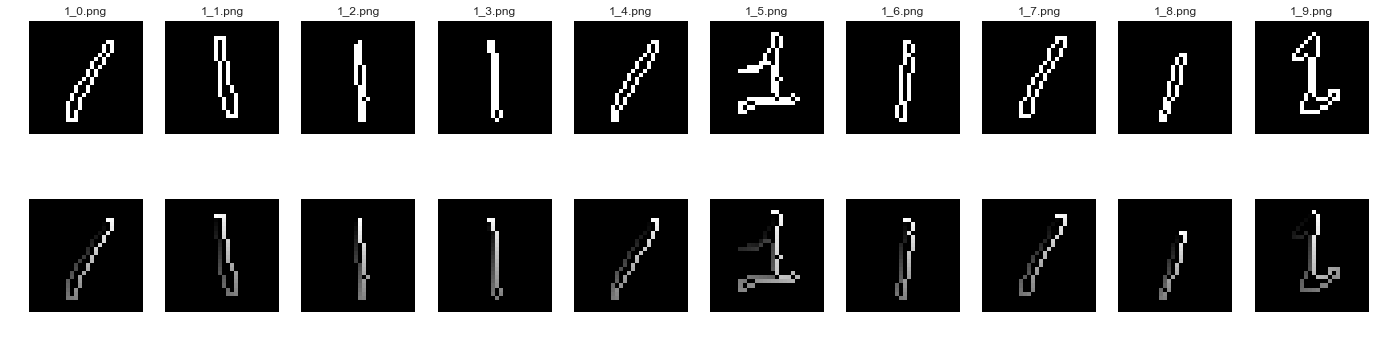

In [9]:
zero_outside_contours = get_outside_contours(zero_contours)
one_outside_contours = get_outside_contours(one_contours)
ordered_contour_zeros = []
ordered_contour_ones = []

for contour in zero_outside_contours:
    ordered_contour = np.zeros_like(zero_contours[0])
    for i in range(len(contour)):
        ordered_contour[contour[i]]= i
    ordered_contour_zeros.append(ordered_contour)
    
for contour in one_outside_contours:
    ordered_contour = np.zeros_like(one_contours[0])
    for i in range(len(contour)):
        ordered_contour[contour[i]]= i
    ordered_contour_ones.append(ordered_contour)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], zero_contours, zeros_names, axes[1], ordered_contour_zeros):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(ones_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], one_contours, ones_names, axes[1], ordered_contour_ones):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Extracting Fourier descriptors

In [10]:
def fourier_description(contours, coeffs):
    L = len(coeffs)
    conts = len(contours)
    descriptors = np.zeros((L,conts), dtype=complex)
    
    for l in range(L):
        for c in range(conts):
            for k in range(len(contours[c])):
                descriptors[l,c] += complex(contours[c][k][0], contours[c][k][1])*cmath.exp(-1j*2.0*cmath.pi*k*coeffs[l]/len(contours[c]) )
                
            descriptors[l,c] = abs(descriptors[l,c])
    
    return np.real(descriptors)  

Let's plot our Fourier descriptors on a 2D plane with and without scaling.

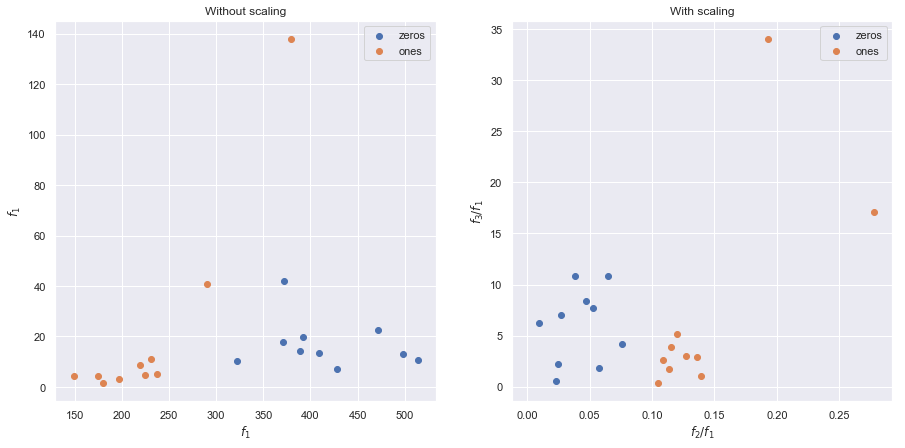

In [11]:
fontsize = 12  # font size for the axis labels

# Extracting the Fourier descriptors from zero and one contours
descriptors_zero = fourier_description(zero_outside_contours, [1,2])
descriptors_one = fourier_description(one_outside_contours, [1,2])

# Plotting our Fourier descriptors without scaling
f, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].scatter(descriptors_zero[0], descriptors_zero[1], label='zeros')
ax[0].scatter(descriptors_one[0], descriptors_one[1], label='ones')
ax[0].legend()
ax[0].set_title('Without scaling')
ax[0].set_xlabel(r'$f_1$', fontsize=fontsize)
ax[0].set_ylabel(r'$f_1$', fontsize=fontsize)

# Extracting the Fourier descriptors with scaling
descriptors_zero = fourier_description(zero_outside_contours, [3,4,1])
descriptors_one = fourier_description(one_outside_contours, [3,4,1])
scaled_descriptors_zero = np.divide(descriptors_zero[0:2], descriptors_zero[2])
scaled_descriptors_one = np.divide(descriptors_one[0:2], descriptors_one[2])
    
# Plotting our Fourier descriptors with scaling
ax[1].scatter(scaled_descriptors_zero[0], descriptors_zero[1], label='zeros')
ax[1].scatter(scaled_descriptors_one[0], descriptors_one[1], label='ones')
ax[1].legend()
ax[1].set_title('With scaling')
ax[1].set_xlabel(r'$f_2/f_1$', fontsize=fontsize)
ax[1].set_ylabel(r'$f_3/f_1$', fontsize=fontsize);

### 1.3 Additional method(s)

As showed above the Fourier descriptors are separating our images perfectly into group of zeros and group of ones. Let us try other features that may discriminate our data.

We would first try really simple features:

- Perimeter of the object
- Area of the object
- Compacity of the object

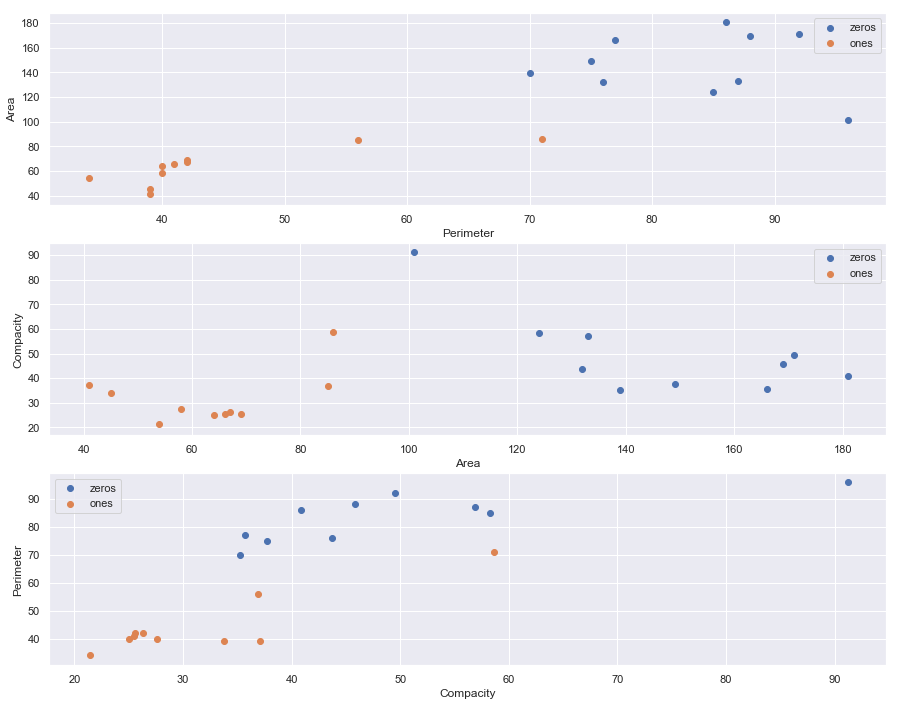

In [12]:
# Extracting perimeters from our objects
zero_perimeters, one_perimeters  = [zero_contour.sum().sum() for zero_contour in zero_contours], \
    [one_contour.sum().sum() for one_contour in one_contours]

# Extracting area values from our objects
zero_areas, one_areas = [zero_region.sum().sum() for zero_region in zero_regions], \
    [one_region.sum().sum() for one_region in one_regions]

# Calculating compacity for our objects
zero_compacities, one_compacities = [P*P/A for P, A in zip(zero_perimeters, zero_areas)], \
    [P*P/A for P, A in zip(one_perimeters, one_areas)]

# Plotting 3 plots for all pairs: (perimeter, area), (area, compacity), (compacity, perimeter)
f, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].scatter(zero_perimeters, zero_areas, label='zeros')
ax[0].scatter(one_perimeters, one_areas, label='ones')
ax[0].legend()
ax[0].set_xlabel('Perimeter')
ax[0].set_ylabel('Area')

ax[1].scatter(zero_areas, zero_compacities, label='zeros')
ax[1].scatter(one_areas, one_compacities, label='ones')
ax[1].set_xlabel('Area')
ax[1].set_ylabel('Compacity')
ax[1].legend()

ax[2].scatter(zero_compacities, zero_perimeters, label='zeros')
ax[2].scatter(one_compacities, one_perimeters, label='ones')
ax[2].set_xlabel('Compacity')
ax[2].set_ylabel('Perimeter')
ax[2].legend();

We may observe that *perimeter* and *area* features nicely separate our images into corresponding groups. Indeed, the shapes of zeros and ones vary significantly and could be easily separated according to their *perimeter* and *area*. *Compacity*, in turn, struggles to perform the same. We see that this feature separates most of the images if one define the threshold at 40, for instance. However, we still misclassify almost 5 images. We suppose this could be due to the fact that both zeros and ones have similar *compactness* as they have the same line widths.

Now let us calculate the object *moments*, also explained in the lecture. We will directly use the [Hu moments](https://en.wikipedia.org/wiki/Image_moment) which are invariant to translation, scale and rotation. We will start by implementing some auxiliary functions.

In [13]:
def get_moment(binary_image, i, j):
    """
        Get M_i_j - i-th and j-th moment of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
            
        Returns
        -------
        int
            The M_i_j moment.
    """
    
    M_i_j = 0
    
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            M_i_j += k**i * l**j * binary_image[k, l]
            
    return M_i_j
            
def get_centered_moment(binary_image, i, j, with_scaled=True):
    """
        Get centered M_i_j of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
        with_scaled : boolean
            True if scale the centered moment, False if not
            
        Returns
        -------
        float or (float, float)
            If with_scaled is True returns unscaled and scaled
            centered moment, if with_scaled is False returns
            only centered moment.
    """
    
    # Getting "the centers of gravity"
    k_mean = get_moment(binary_image, 1, 0)/get_moment(binary_image, 0, 0)
    l_mean = get_moment(binary_image, 0, 1)/get_moment(binary_image, 0, 0)
    
    # Getting the scaling factor
    mu_0_0 = get_moment(binary_image, 0, 0)
    
    mu_i_j = 0
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            mu_i_j += (k - k_mean)**i * (l - l_mean)**j * binary_image[k, l]
    
    # Applying scaling
    eta_i_j = mu_i_j/mu_0_0**((i+j)/2 + 1)
    
    if with_scaled:
        return mu_i_j, eta_i_j
    else:
        return mu_i_j
    
def get_first_4_Hu_moments(binary_image, with_scaled=True):
    """
        Get first 4 Hu moments, which are invariant to rotation.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        
        with_scaled : boolean
            True if scale the HU moment, False if not
            
        Returns
        -------
        list of 4 elements
            First 4 HU moments.
    """
    if with_scaled:
        _, val_0_2 = get_centered_moment(binary_image, 0, 2)
        _, val_2_0 = get_centered_moment(binary_image, 2, 0)
        _, val_1_1 = get_centered_moment(binary_image, 1, 1)
        _, val_1_2 = get_centered_moment(binary_image, 1, 2)
        _, val_2_1 = get_centered_moment(binary_image, 2, 1)
        _, val_3_0 = get_centered_moment(binary_image, 3, 0)
        _, val_0_3 = get_centered_moment(binary_image, 0, 3)
    else:
        val_0_2 = get_centered_moment(binary_image, 0, 2, with_scaled=False)
        val_2_0 = get_centered_moment(binary_image, 2, 0, with_scaled=False)
        val_1_1 = get_centered_moment(binary_image, 1, 1, with_scaled=False)
        val_1_2 = get_centered_moment(binary_image, 1, 2, with_scaled=False)
        val_2_1 = get_centered_moment(binary_image, 2, 1, with_scaled=False)
        val_3_0 = get_centered_moment(binary_image, 3, 0, with_scaled=False)
        val_0_3 = get_centered_moment(binary_image, 0, 3, with_scaled=False)
    
    I_1 = val_2_0 + val_0_2
    I_2 = (val_2_0 - val_0_2)**2 + 4*val_1_1**2
    I_3 = (val_3_0 - 3*val_1_2)**2 + (3*val_2_1 - val_0_3)**2
    I_4 = (val_3_0 + val_1_2)**2 + (val_2_1 + val_0_3)**2
    
    return [I_1, I_2, I_3, I_4]

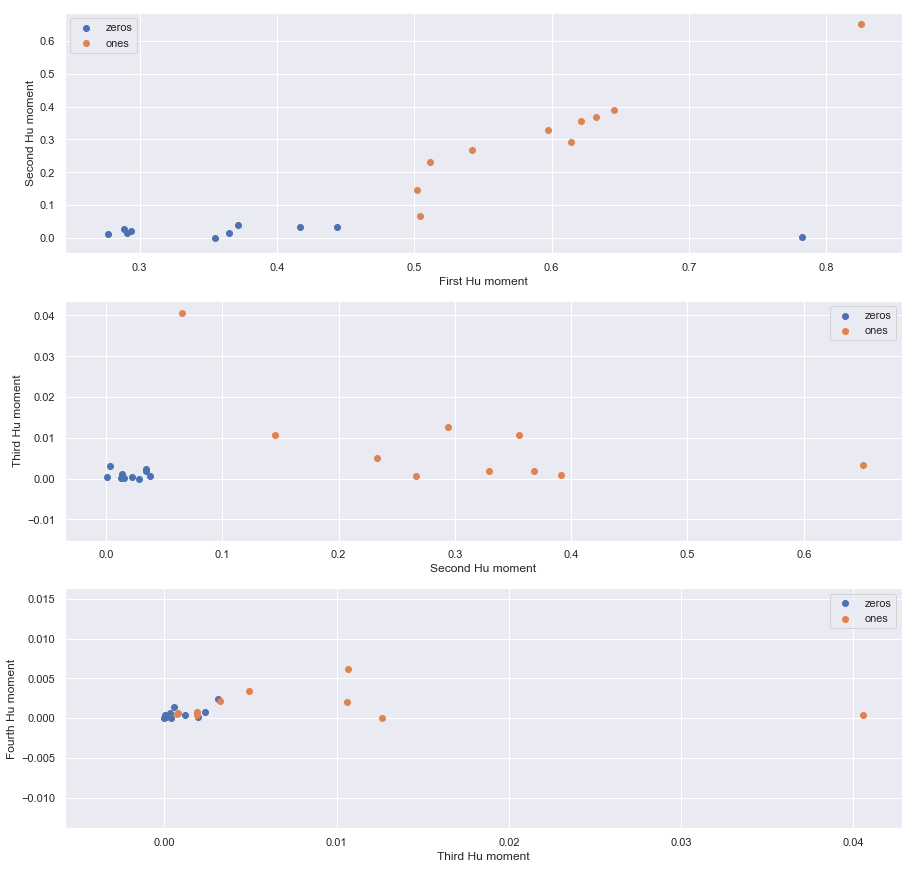

In [15]:
# Getting the Hu moments
zero_HU_moments = np.array([get_first_4_Hu_moments(zero_region) for zero_region in zero_regions])
one_HU_moments = np.array([get_first_4_Hu_moments(one_region) for one_region in one_regions])

# Plotting 3 plots for all pairs: (I_1, I_2), (I_2, I_3), (I_3, I_4)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].scatter(zero_HU_moments[:, 0], zero_HU_moments[:, 1], label='zeros')
ax[0].scatter(one_HU_moments[:, 0], one_HU_moments[:, 1], label='ones')
ax[0].legend()
ax[0].set_xlabel('First Hu moment')
ax[0].set_ylabel('Second Hu moment')

ax[1].scatter(zero_HU_moments[:, 1], zero_HU_moments[:, 2], label='zeros')
ax[1].scatter(one_HU_moments[:, 1], one_HU_moments[:, 2], label='ones')
ax[1].set_xlabel('Second Hu moment')
ax[1].set_ylabel('Third Hu moment')
ax[1].legend()

ax[2].scatter(zero_HU_moments[:, 2], zero_HU_moments[:, 3], label='zeros')
ax[2].scatter(one_HU_moments[:, 2], one_HU_moments[:, 3], label='ones')
ax[2].set_xlabel('Third Hu moment')
ax[2].set_ylabel('Fourth Hu moment')
ax[2].legend();

We could observe that the first 2 Hu moments perform much better than the third and the fourth. Both the $I_1$ and $I_2$ allows one to separate the data by using vertical line except for two outliers. The higher-order moments perform much worse because they are almost around zero - our data distribution is not [skewed](https://en.wikipedia.org/wiki/Moment_(mathematics)#Skewness).

Let us move on to axis of inertia. We will compute the vectors corresponding to the axis of inertia as the eigenvectors of the covariance matrix of the set of the object coordinates.

In [16]:
# Getting the object coordinates (the center of the axis is left bottom corner of the image)
zero_region_coords, one_region_coords = [(28 - np.where(zero_region)[1], 28 - np.where(zero_region)[0]) for zero_region in zero_regions], \
    [(28 - np.where(one_region)[1], 28 - np.where(one_region)[0]) for one_region in one_regions]

# Getting the covariance matrices
zero_covs, one_covs = [np.cov(zero_coords) for zero_coords in zero_region_coords], \
    [np.cov(one_coords) for one_coords in one_region_coords]

# Calculating the eigenvalues and vectors
zero_eigs, one_eigs = [eig(zero_cov) for zero_cov in zero_covs], [eig(one_cov) for one_cov in one_covs]

Let us visualize the results by plotting the axis of inertia on the images.

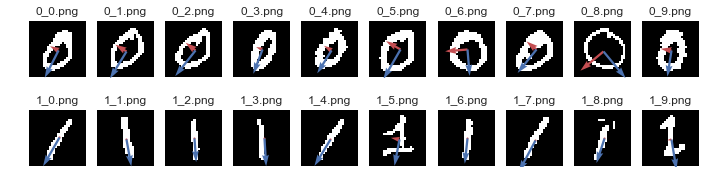

In [17]:
# Getting the centers of gravity to plot the axis of inertia
zero_x_centers = [28 - get_moment(image, 0, 1)/get_moment(image, 0, 0) for image in zero_regions]
one_x_centers = [28 - get_moment(image, 0, 1)/get_moment(image, 0, 0) for image in one_regions]
zero_y_centers = [28 - get_moment(image, 1, 0)/get_moment(image, 0, 0) for image in zero_regions]
one_y_centers = [28 - get_moment(image, 1, 0)/get_moment(image, 0, 0) for image in one_regions]

# Setting the parameters for the arrows
scale = 70
width = 0.04

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, zero_eig, x_origin, y_origin in zip(axes[0], zero_regions, zeros_names, zero_eigs, zero_x_centers, zero_y_centers):
    origin = [x_origin, y_origin]  # The center of the axis
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    ax.plot(14, 14, 'r')
    zero_vecs = np.multiply(zero_eig[1], zero_eig[0][:, np.newaxis])
    ax.quiver(*origin, *zero_vecs[0], color='r', scale=scale, width=width)
    ax.quiver(*origin, *zero_vecs[1], color='b', scale=scale, width=width)

for ax, im, nm, one_eig, x_origin, y_origin in zip(axes[1], one_regions, ones_names, one_eigs, one_x_centers, one_y_centers):
    origin = [x_origin, y_origin]  # The center of the axis
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    one_vecs = np.multiply(one_eig[1], one_eig[0][:, np.newaxis])
    ax.quiver(*origin, *one_vecs[0], color='r', scale=scale, width=width)
    ax.quiver(*origin, *one_vecs[1], color='b', scale=scale, width=width)

In the visualization above blue axis correspond to the eigenvector with the biggest eigenvalue (the direction of the highest variance), while red axis correspond to the second eigenvalue. We could observe that ones are more "squeezed" in a horizontal direction in comparison with zeros, thus we could use the eigenvalue corresponding to red axis as a feature. 

Let us see if we are right.

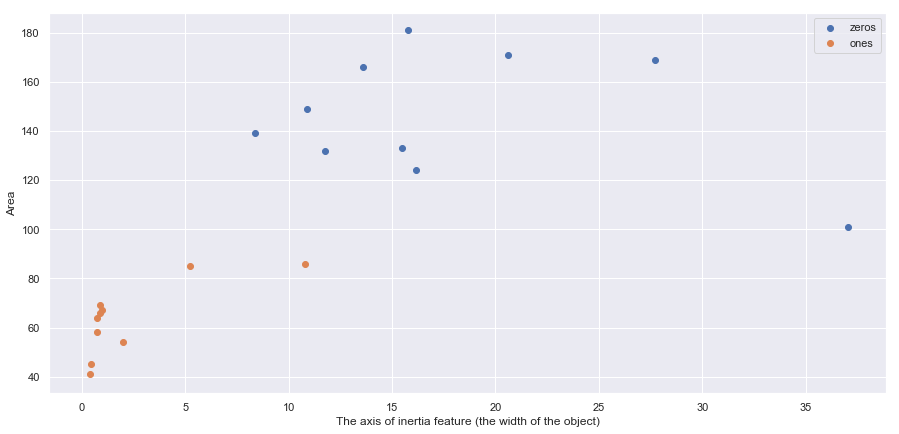

In [18]:
# Getting the "width" of the objects
zero_eigenwidths = [zero_eig[0][0] for zero_eig in zero_eigs]
one_eigenwidths = [one_eig[0][0] for one_eig in one_eigs]

# Plotting axis of inertia features with area features
f, ax = plt.subplots(figsize=(15, 7))
ax.scatter(zero_eigenwidths, zero_areas, label='zeros')
ax.scatter(one_eigenwidths, one_areas, label='ones')
ax.legend()
ax.set_xlabel('The axis of inertia feature (the width of the object)')
ax.set_ylabel('Area');

We could conclude that for the majority of the objects the eigenvalue which correspond to the width of the objects perform well.

Another way of seperating one and zeros is to perform dimension reduction (such as **PCA** or **TSNE**) on the original image (raw pixels). In order to get better results, we standartize the data before performing the dimension reductions.

In [19]:
# Standardize the data
zeros_reshaped = zeros_im.reshape(len(zeros_im), -1)
ones_reshaped = ones_im.reshape(len(ones_im), -1)
concat = np.concatenate((zeros_reshaped, ones_reshaped), axis = 0) 
standardized_data = StandardScaler().fit_transform(concat)

# Creating the corresponding labels
labels = [0]*len(zeros_im) + [1]*len(ones_im)

PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

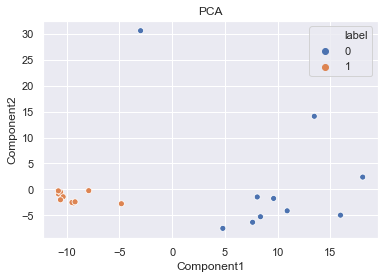

In [33]:
# Compute PCA
pca = decomposition.PCA()
pca.n_components = 2
res = pca.fit_transform(standardized_data)
res = res.T

# Plot
df = pd.DataFrame(data= {'Component1' : res[0], 'Component2' : res[1], 'label':labels})
sns.scatterplot(x = df.Component1, y = df.Component2, hue=df.label)
ax = plt.gca().set_title("PCA")

T-distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

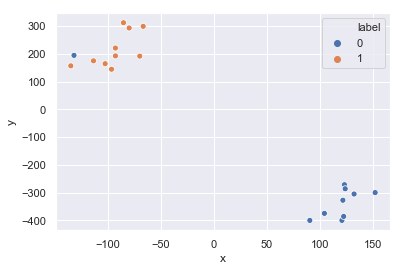

In [34]:
# Compute TSNE
model = TSNE(n_components=2, random_state=0, perplexity=2)
res = model.fit_transform(standardized_data)
res = res.T

# Plot
df = pd.DataFrame(data= {'x' : res[0], 'y' : res[1], 'label':labels})
sns.scatterplot(x = df.x, y = df.y, hue=df.label)

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

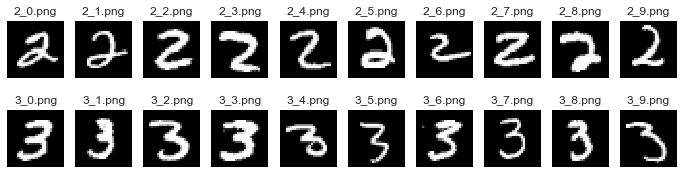

In [57]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion

Now we will try to separate twos and threes. This task should be harder because both of them have similar shapes, areas and, probably, other features we used before. Anyway, let us try Fourier descriptors.

We extract the contours the same way we did in the previous section.

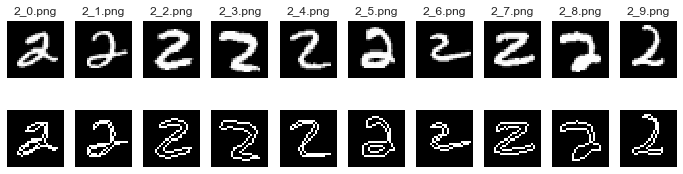

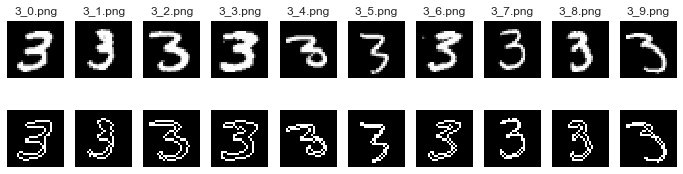

In [133]:
# Compute the object regions
two_regions = [image > 128 for image in twos_im]
three_regions = [image > 128 for image in threes_im]

# Compute contours
two_contours = [get_contour(img) for img in twos_im]
three_contours = [get_contour(img) for img in threes_im]
    
# Plot
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, img, name, ax2, img2 in zip(axes[0], twos_im, twos_names, axes[1], two_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))    
for ax, img, name, ax2, img2 in zip(axes[0], threes_im, threes_names, axes[1], three_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

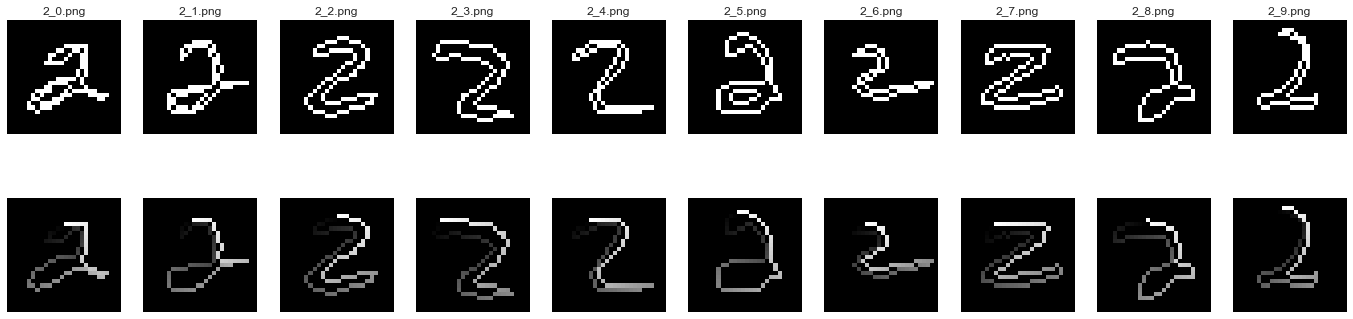

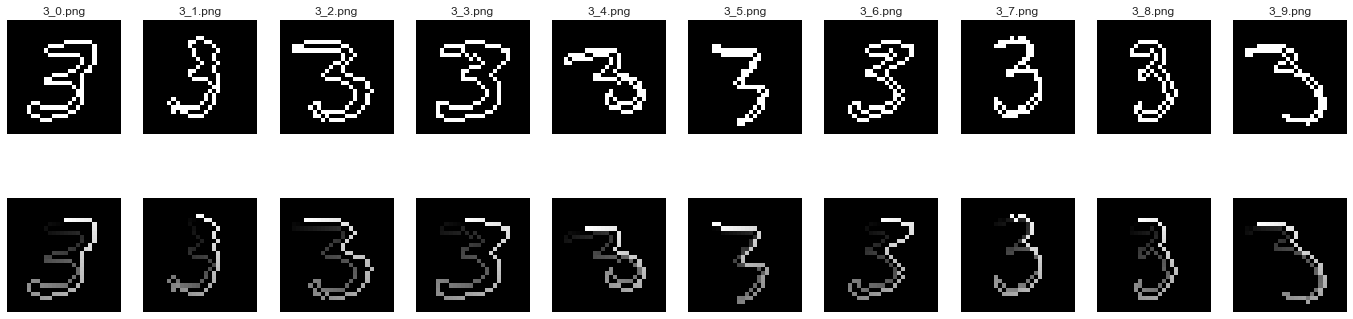

In [134]:
two_outside_contours = get_outside_contours(two_contours)
three_outside_contours = get_outside_contours(three_contours)
ordered_contour_twos = []
ordered_contour_threes = []

for contour in two_outside_contours:
    ordered_contour = np.zeros_like(two_contours[0])
    for i in range(len(contour)):
        ordered_contour[contour[i]]= i
    ordered_contour_twos.append(ordered_contour)
    
for contour in three_outside_contours:
    ordered_contour = np.zeros_like(three_contours[0])
    for i in range(len(contour)):
        ordered_contour[contour[i]]= i
    ordered_contour_threes.append(ordered_contour)
    
fig, axes = plt.subplots(2, len(twos_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], two_contours, twos_names, axes[1], ordered_contour_twos):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(threes_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], three_contours, threes_names, axes[1], ordered_contour_threes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

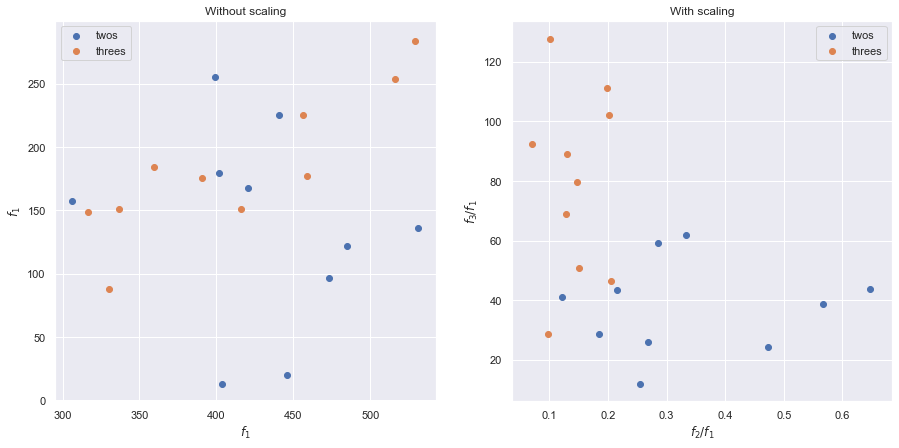

In [135]:
fontsize = 12  # font size for the axis labels

# Extracting the Fourier descriptors from two and three contours
descriptors_two = fourier_description(two_outside_contours, [1,2])
descriptors_three = fourier_description(three_outside_contours, [1,2])

# Plotting our Fourier descriptors without scaling
f, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].scatter(descriptors_two[0], descriptors_two[1], label='twos')
ax[0].scatter(descriptors_three[0], descriptors_three[1], label='threes')
ax[0].legend()
ax[0].set_title('Without scaling')
ax[0].set_xlabel(r'$f_1$', fontsize=fontsize)
ax[0].set_ylabel(r'$f_1$', fontsize=fontsize)

# Extracting the Fourier descriptors with scaling
descriptors_two = fourier_description(two_outside_contours, [3,4,1])
descriptors_three = fourier_description(three_outside_contours, [3,4,1])
scaled_descriptors_two = np.divide(descriptors_two[0:2], descriptors_two[2])
scaled_descriptors_three = np.divide(descriptors_three[0:2], descriptors_three[2])
    
# Plotting our Fourier descriptors with scaling
ax[1].scatter(scaled_descriptors_two[0],descriptors_two[1], label='twos')
ax[1].scatter(scaled_descriptors_three[0],descriptors_three[1], label='threes')
ax[1].legend()
ax[1].set_title('With scaling')
ax[1].set_xlabel(r'$f_2/f_1$', fontsize=fontsize)
ax[1].set_ylabel(r'$f_3/f_1$', fontsize=fontsize);

Now Fourier descriptors, especially unscaled, struggle to discriminate two and threes. Still for the scaled Fourier descriptors we could conclude that objects can be linearly separated, even though less clearly.

Let us try other features in the next order:

- Hu moments
- Perimeter
- Area
- Compacity
- Principal components

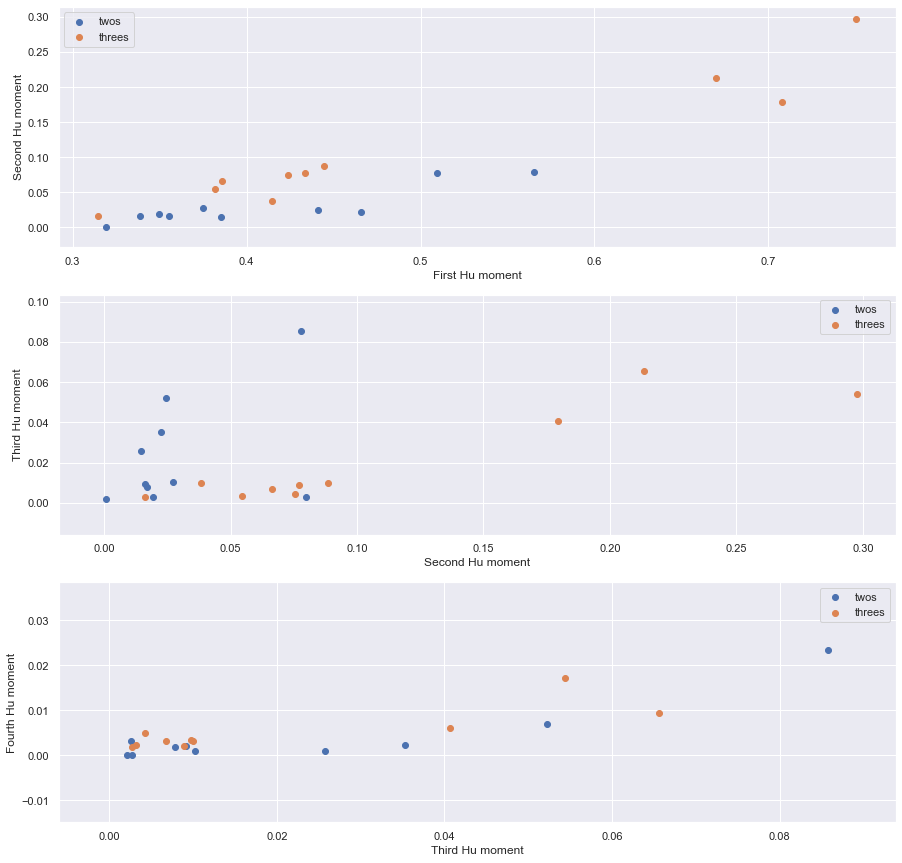

In [136]:
# Getting the Hu moments
two_Hu_moments = np.array([get_first_4_Hu_moments(two_region) for two_region in two_regions])
three_Hu_moments = np.array([get_first_4_Hu_moments(three_region) for three_region in three_regions])

# Plotting 3 plots for all pairs: (I_1, I_2), (I_2, I_3), (I_3, I_4)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].scatter(two_Hu_moments[:, 0], two_Hu_moments[:, 1], label='twos')
ax[0].scatter(three_Hu_moments[:, 0], three_Hu_moments[:, 1], label='threes')
ax[0].legend()
ax[0].set_xlabel('First Hu moment')
ax[0].set_ylabel('Second Hu moment')

ax[1].scatter(two_Hu_moments[:, 1], two_Hu_moments[:, 2], label='twos')
ax[1].scatter(three_Hu_moments[:, 1], three_Hu_moments[:, 2], label='threes')
ax[1].set_xlabel('Second Hu moment')
ax[1].set_ylabel('Third Hu moment')
ax[1].legend()

ax[2].scatter(two_Hu_moments[:, 2], two_Hu_moments[:, 3], label='twos')
ax[2].scatter(three_Hu_moments[:, 2], three_Hu_moments[:, 3], label='threes')
ax[2].set_xlabel('Third Hu moment')
ax[2].set_ylabel('Fourth Hu moment')
ax[2].legend();

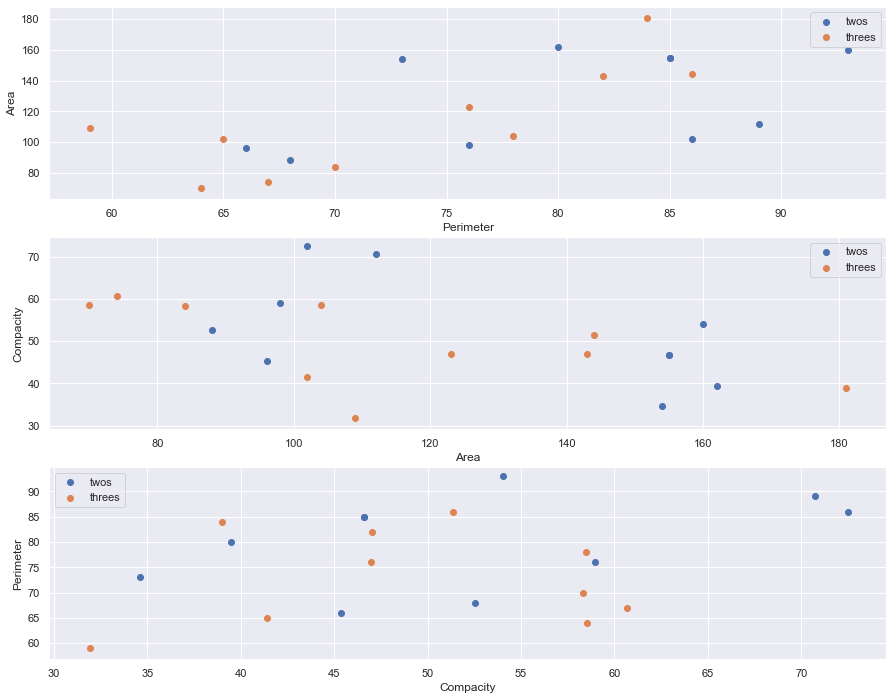

In [73]:
# Extracting perimeters from our objects
two_perimeters, three_perimeters  = [two_contour.sum().sum() for two_contour in two_contours], \
    [three_contour.sum().sum() for three_contour in three_contours]

# Extracting area values from our objects
two_areas, three_areas = [two_region.sum().sum() for two_region in two_regions], \
    [three_region.sum().sum() for three_region in three_regions]

# Calculating compacity for our objects
two_compacities, three_compacities = [P*P/A for P, A in zip(two_perimeters, two_areas)], \
    [P*P/A for P, A in zip(three_perimeters, three_areas)]

# Plotting 3 plots for all pairs: (perimeter, area), (area, compacity), (compacity, perimeter)
f, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].scatter(two_perimeters, two_areas, label='twos')
ax[0].scatter(three_perimeters, three_areas, label='threes')
ax[0].legend()
ax[0].set_xlabel('Perimeter')
ax[0].set_ylabel('Area')

ax[1].scatter(two_areas, two_compacities, label='twos')
ax[1].scatter(three_areas, three_compacities, label='threes')
ax[1].set_xlabel('Area')
ax[1].set_ylabel('Compacity')
ax[1].legend()

ax[2].scatter(two_compacities, two_perimeters, label='twos')
ax[2].scatter(three_compacities, three_perimeters, label='threes')
ax[2].set_xlabel('Compacity')
ax[2].set_ylabel('Perimeter')
ax[2].legend();

In [71]:
# Standardize the data
twos_reshaped = twos_im.reshape(len(twos_im), -1)
threes_reshaped = threes_im.reshape(len(threes_im), -1)
concat = np.concatenate((twos_reshaped, threes_reshaped), axis = 0) 
standardized_data = StandardScaler().fit_transform(concat)

# Creating the corresponding labels
labels = [0]*len(twos_im) + [1]*len(threes_im)

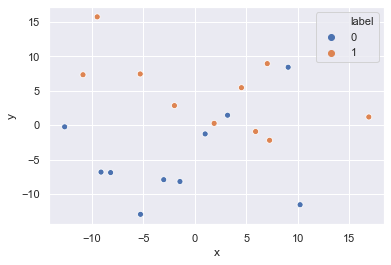

In [72]:
# Compute PCA
pca = decomposition.PCA()
pca.n_components = 2
res = pca.fit_transform(standardized_data)
res = res.T

# Plot
df = pd.DataFrame(data= {'x' : res[0], 'y' : res[1], 'label':labels})
sns.scatterplot(x = df.x, y = df.y, hue=df.label)

All of these features struggle to discriminate our data. Maybe we should use the ***Freeman code, or distance map***??

### FIXME ADD FREEMAN CODE IMPLEMENTATION OR DISTANCE MAP